# Global minimizers

*(sorry for the American spelling...)*

`scipy` includes multiple minimizers, but most of them are *local* minimizers, and get stuck in local minima[1]. It does include some *global* minimizers which we shall investigate.

## The problem

[This wiki page](https://en.wikipedia.org/wiki/Test_functions_for_optimization) lists some nice minimization testers, and the one we shall be using is the Easom function:

![Easom function](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Easom_function.pdf/page1-640px-Easom_function.pdf.jpg)

It is a flat surface with a very sharp minima located at ($\pi$, $\pi$):

$$f(x, y) = -\cos(x)\cos(y)\exp\left(-((x - \pi)^2 + (y - \pi)^2)\right)$$

which can be generalised to

$$f(x, y, x_0, y_0) = -\cos(x)\cos(y)\exp\left(-((x - x_0)^2 + (y - y_0)^2)\right)$$

[1]: minima corresponds to "distance from solution" type estimators e.g. $\chi^2$

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize as opt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)

sns.set(style='ticks', context='poster')

In [2]:
def easom(p):
    x, y = p
    return -(
        np.cos(x) *
        np.cos(y) *
        np.exp(-((x - np.pi) ** 2 + (y - np.pi) ** 2)))

In [3]:
x, y = (np.linspace(-5, 5, 250), np.linspace(-5, 5, 250))
X, Y = np.meshgrid(x, y)
Z = easom((X, Y))

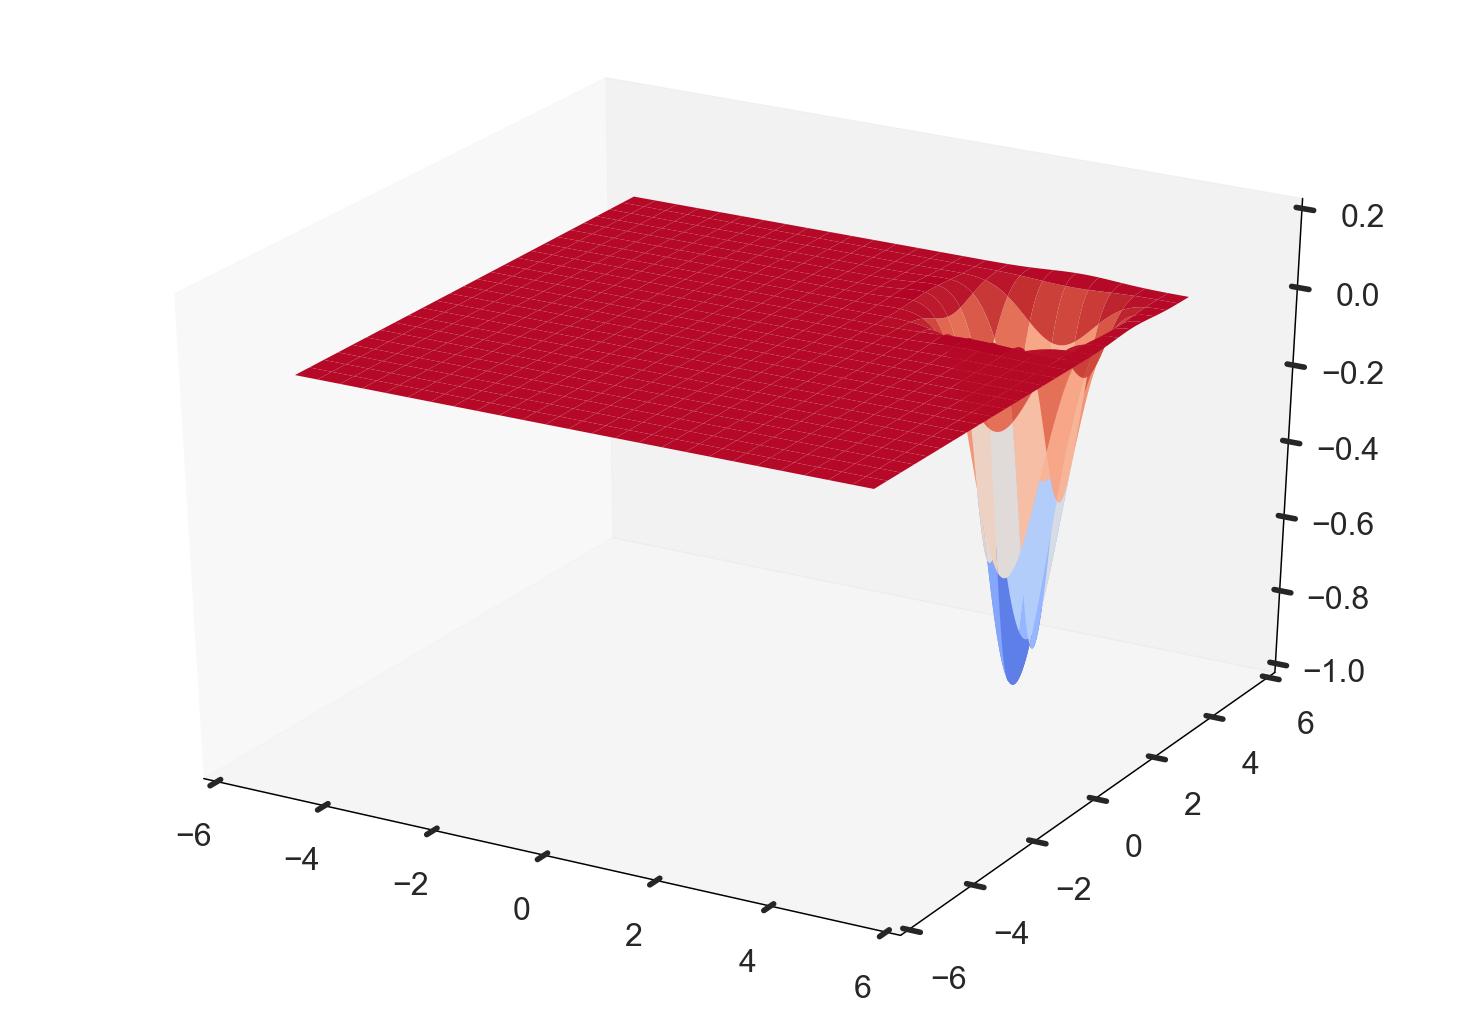

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='coolwarm', linewidth=0)
ax.grid(False)

## `scipy.optimize.minimize`

First we try the default `minimize` function, which requires a starting point. We first give it a reasonable guess to see if it finds the solution

In [5]:
def assess_result(solution, target=(np.pi, np.pi)):
    '''Goodness of fit assessor. Larger is better'''
    return -np.log10(np.sqrt((solution[0] - target[0]) ** 2 + (solution[1] - target[1]) ** 2))

def test_minimizer(minimizer, *args, **kwargs):
    result = minimizer(easom, *args, **kwargs)
    print(result.x)
    print(assess_result(result.x))

In [6]:
%time test_minimizer(opt.minimize, x0=(3, 3))

[ 3.14159261  3.14159261]
7.2239292804
CPU times: user 1.05 ms, sys: 128 µs, total: 1.18 ms
Wall time: 1.08 ms


Now start it far away, in the flat region

In [7]:
%time test_minimizer(opt.minimize, x0=(-4, 4))

[-4.  4.]
-0.856909891592
CPU times: user 529 µs, sys: 62 µs, total: 591 µs
Wall time: 539 µs


This "solution" is the initial starting point. As the surface is flat at that point, no matter what direction the minimizer takes the change in goodness of fit is the same, so it assumes it's found the best solution.

## Global minimizers

There are two in `scipy`: `differential_evolution` and `basinhopping`.

### `differential_evolution`

My understanding is that this performs a genetic algorithm like mutation and mixing analysis. You supply the bounds of the parameter space to search, and the sampler picks "chromosomes" in this space and mixes and mutates to find the best solution. The function optionally allows a "normal" descent minimizer to finish the job to achieve a higher accuracy.

In [8]:
%time test_minimizer(opt.differential_evolution, [(-5, 5), (-5, 5)])

[ 3.14159226  3.14159434]
5.76164179626
CPU times: user 21.5 ms, sys: 4.74 ms, total: 26.3 ms
Wall time: 22.5 ms


We see when running it a second time that there is some randomness:

In [9]:
%time test_minimizer(opt.differential_evolution, [(-5, 5), (-5, 5)])

[ 3.1415925  3.1415931]
6.32382674573
CPU times: user 15.6 ms, sys: 3.47 ms, total: 19.1 ms
Wall time: 16.3 ms


### `basinhopping`

This sampler is an annealing sampler, similar to MCMC.

In [10]:
%time test_minimizer(opt.basinhopping, (-4, 4))

[-2.84304011  2.82207186]
-0.777655606613
CPU times: user 20.3 ms, sys: 3.62 ms, total: 23.9 ms
Wall time: 21 ms


This solution is not very good, but it defaults to 100 iterations. Let's turn that up and see if it has more success

In [11]:
%time test_minimizer(opt.basinhopping, (-4, 4), niter=1000)

[-2.89596878  4.18807652]
-0.787289220657
CPU times: user 121 ms, sys: 17.5 ms, total: 139 ms
Wall time: 126 ms


In [12]:
%time test_minimizer(opt.basinhopping, (-4, 4), niter=1000)

[ 3.14159265  3.14159265]
8.32931193779
CPU times: user 391 ms, sys: 6.67 ms, total: 398 ms
Wall time: 393 ms


The stochastic nature means with this particular function it either needs lots of iterations or running from multiple start locations. This kind of analysis is starting to sound like MCMC and the way `emcee works`.

## Conclusions

The global minimisation techniques presented both achieve the desired solution for this particular function, but the `differential_evolution` algorithm appears to be much faster.

There are parameters to tweak for both methods which have not been explored.